In [1]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
df = pd.read_csv('increased_transaction_dataset.csv')

In [7]:
# Preprocess dataset
df.columns = df.columns.str.strip() 
df = df.drop(columns=["Unnamed: 0"], errors='ignore') 

# Encode target column
label_encoder = LabelEncoder()
df["FLAG"] = label_encoder.fit_transform(df["FLAG"])

In [9]:
X = df.drop(columns=["FLAG"])
y = df["FLAG"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [11]:
columns = [
    "Avg min between sent tnx",
    "Avg min between received tnx",
    "Time Diff between first and last (Mins)",
    "max value received",
    "avg val received",
    "avg val sent",
    "total Ether sent",
    "total ether balance",
    "ERC20 total Ether received",
    "ERC20 total ether sent",
]

# Log transformation for skewed data
for c in columns:
    if c in X_train.columns:
        X_train[c] = X_train[c].apply(lambda x: np.log(x) if x > 0 else 0)
        X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)

In [13]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
params = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.1, 0.05, 0.01]
}

clf = XGBClassifier(objective='binary:logistic', seed=42, eval_metric='logloss')

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=params,
    scoring='f1',
    cv=skf,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("Test ROC-AUC:", roc_auc)
print("Test F1 Score:", f1)

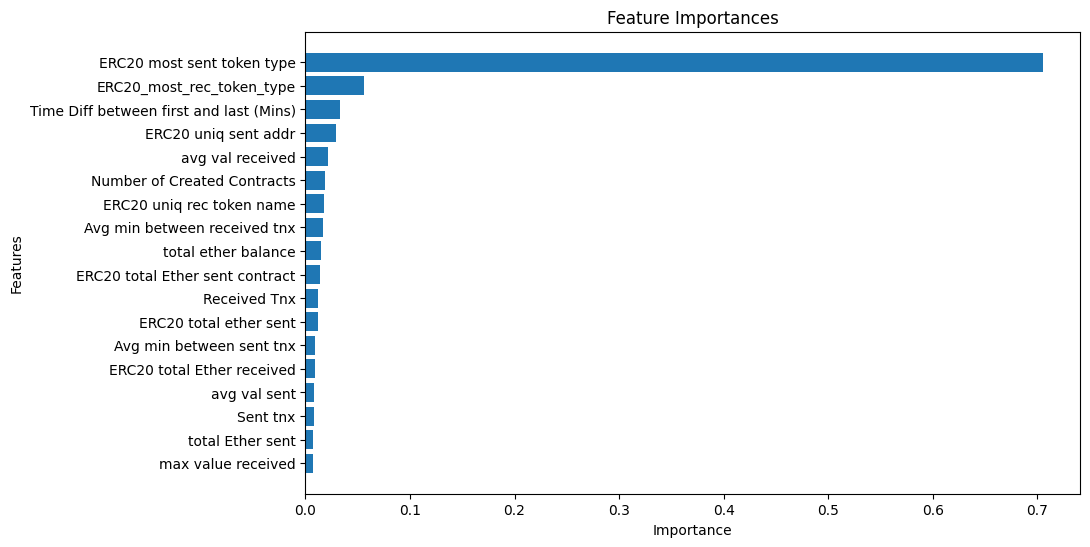

In [140]:
feat_importances = best_model.feature_importances_
indices = np.argsort(feat_importances)
features = X.columns

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(feat_importances)), feat_importances[indices], align="center")
plt.yticks(range(len(feat_importances)), [features[i] for i in indices])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

In [ ]:
plt.figure(figsize=(6, 6))
sb.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [144]:
def model_diagnostic_stats(confusion_matrix):
    tp = confusion_matrix[1, 1]
    tn = confusion_matrix[0, 0]
    fp = confusion_matrix[0, 1]
    fn = confusion_matrix[1, 0]

    p = tp + fn
    n = fp + tn
    pp = tp + fp
    pn = fn + tn

    diagnostic_dict = {
        'recall': tp / p,
        'false_neg_rate': fn / p,
        'false_pos_rate': fp / n,
        'true_neg_rate': tn / n,
        'positive_likelihood_ratio': (tp / p) / (fp / n) if fp > 0 else np.inf,
        'negative_likelihood_ratio': (fn / p) / (tn / n) if tn > 0 else np.inf,
        'precision': tp / pp,
        'false_omission_rate': fn / pn,
        'false_discovery_rate': fp / pp,
        'negative_predictive_value': tn / pn,
        'markedness': (tp / pp) + (tn / pn) - 1,
        'diagnostic_odds_ratio': ((tp / p) / (fp / n)) / ((fn / p) / (tn / n)) if fp > 0 and tn > 0 else np.inf,
        'informedness': (tp / p) + (tn / n) - 1,
        'prevalence_threshold': (np.sqrt((tp / p) * (fp / n)) - (fp / n)) / ((tp / p) - (fp / n)) if (tp / p) != (fp / n) else 0,
        'prevalence': p / (p + n),
        'accuracy': (tp + tn) / (p + n),
        'balanced_accuracy': ((tp / p) + (tn / n)) / 2,
        'F1_score': 2 * tp / (2 * tp + fp + fn),
        'fowlkes_mallows_index': np.sqrt((tp / pp) * (tp / p)),
        'jaccard_index': tp / (tp + fn + fp),
    }

    return diagnostic_dict

stats = model_diagnostic_stats(conf_matrix)

# Print diagnostic stats
print("\nModel Diagnostic Statistics:")
for key, value in stats.items():
    print(f"{key}: {value:.4f}")


Model Diagnostic Statistics:
recall: 0.9974
false_neg_rate: 0.0026
false_pos_rate: 0.0380
true_neg_rate: 0.9620
positive_likelihood_ratio: 26.2312
negative_likelihood_ratio: 0.0027
precision: 0.9892
false_omission_rate: 0.0094
false_discovery_rate: 0.0108
negative_predictive_value: 0.9906
markedness: 0.9798
diagnostic_odds_ratio: 9651.9500
informedness: 0.9594
prevalence_threshold: 0.1634
prevalence: 0.7773
accuracy: 0.9895
balanced_accuracy: 0.9797
F1_score: 0.9933
fowlkes_mallows_index: 0.9933
jaccard_index: 0.9866


In [146]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, precision_recall_curve
from plotly.subplots import make_subplots

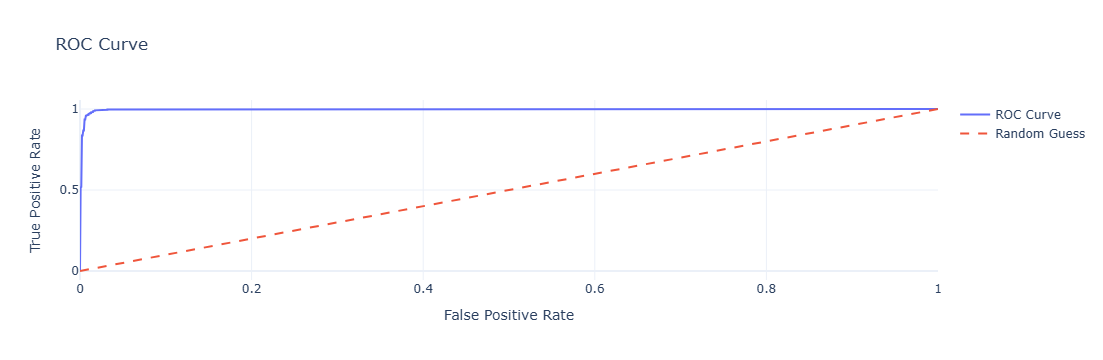

In [148]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_fig = go.Figure()
roc_fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC Curve'))
roc_fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Guess', line=dict(dash='dash')))
roc_fig.update_layout(title='ROC Curve', xaxis_title='False Positive Rate', yaxis_title='True Positive Rate',
                      template='plotly_white')

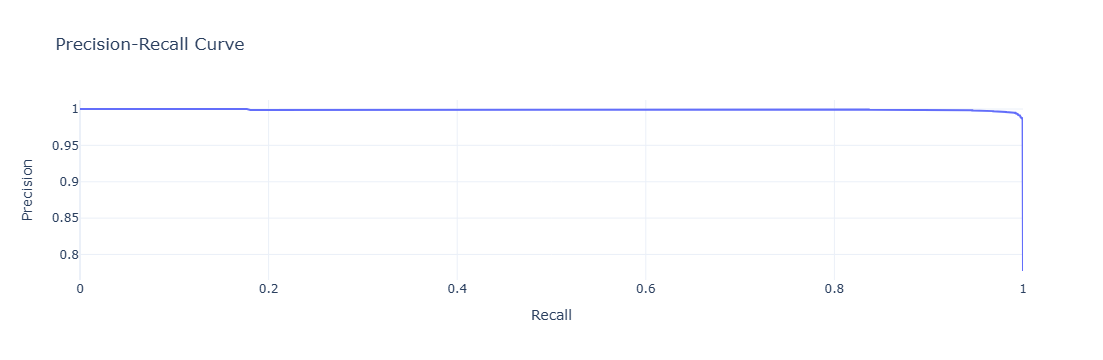

In [150]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_fig = go.Figure()
pr_fig.add_trace(go.Scatter(x=recall, y=precision, mode='lines', name='Precision-Recall Curve'))
pr_fig.update_layout(title='Precision-Recall Curve', xaxis_title='Recall', yaxis_title='Precision',
                     template='plotly_white')

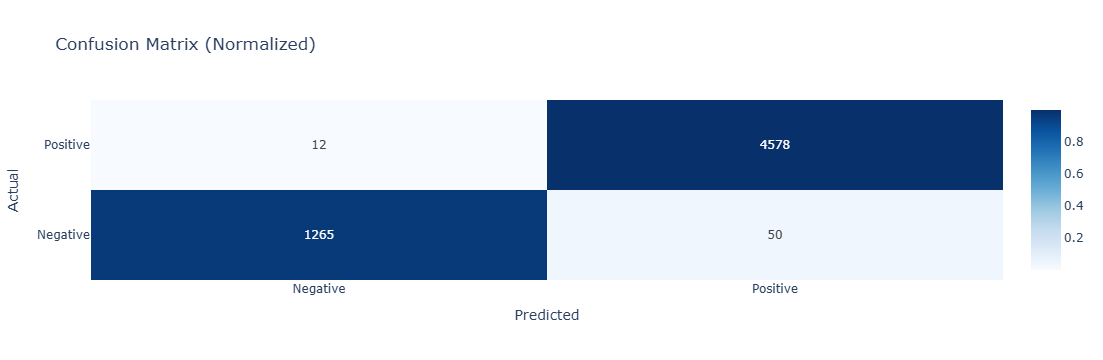

In [152]:
# Confusion Matrix Heatmap
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)
conf_matrix_fig = go.Figure(data=go.Heatmap(z=conf_matrix_norm, x=['Negative', 'Positive'], y=['Negative', 'Positive'],
                                            hoverongaps=False, colorscale='Blues', text=conf_matrix,
                                            texttemplate="%{text}", showscale=True))
conf_matrix_fig.update_layout(title='Confusion Matrix (Normalized)',
                               xaxis_title='Predicted', yaxis_title='Actual',
                               template='plotly_white')

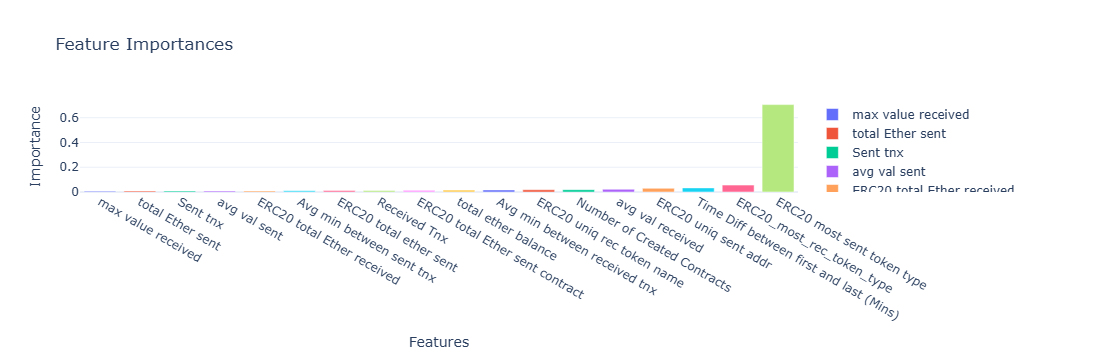

In [154]:
# Feature Importance Plot
feature_fig = go.Figure()
for idx, importance in zip(indices, feat_importances[indices]):
    feature_fig.add_trace(go.Bar(x=[features[idx]], y=[importance], name=features[idx]))
feature_fig.update_layout(title='Feature Importances', xaxis_title='Features', yaxis_title='Importance',
                          template='plotly_white')

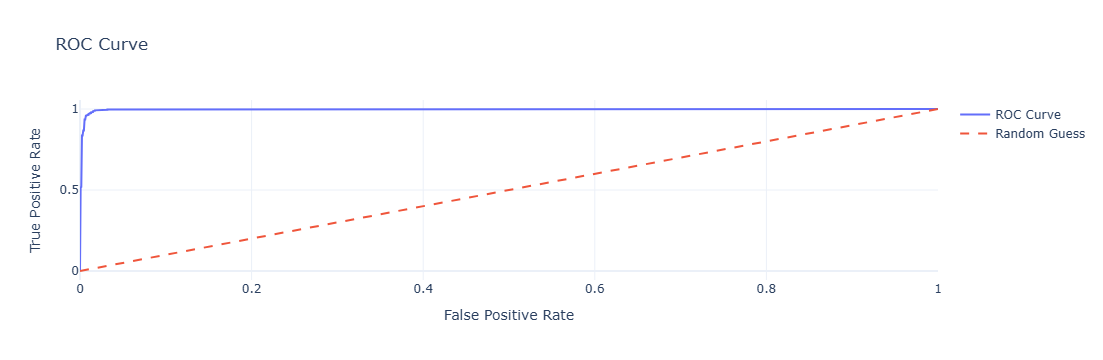

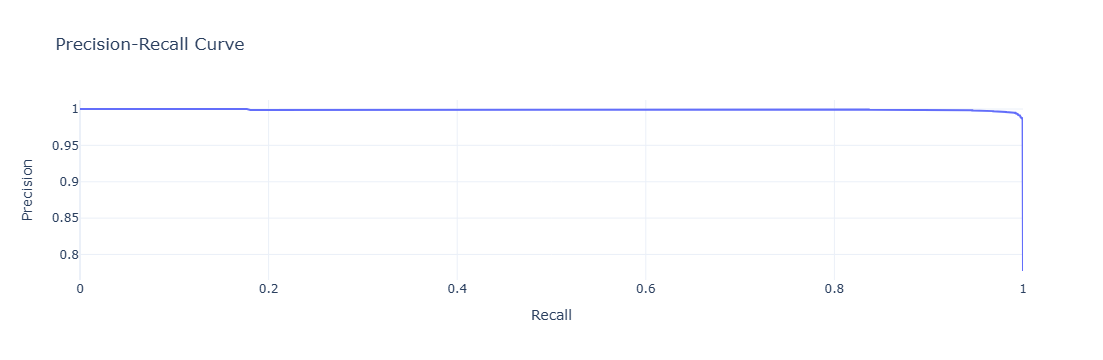

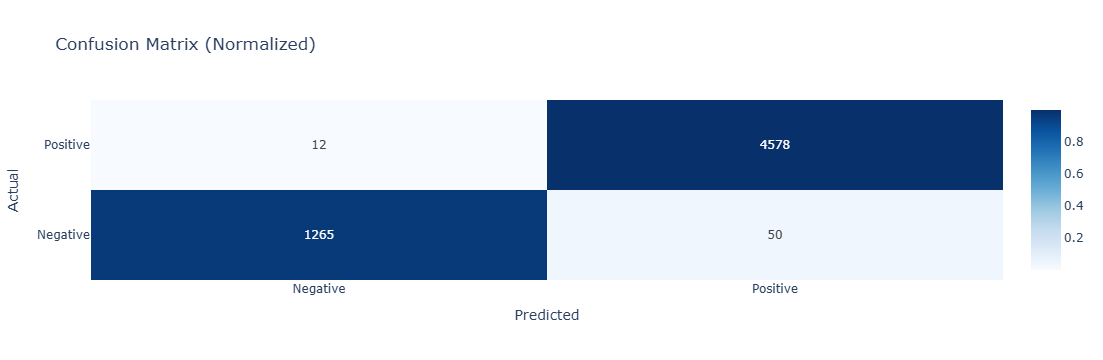

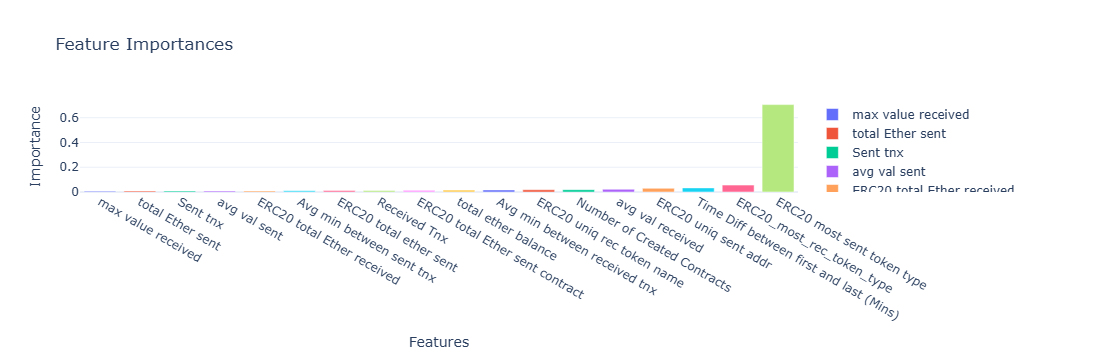

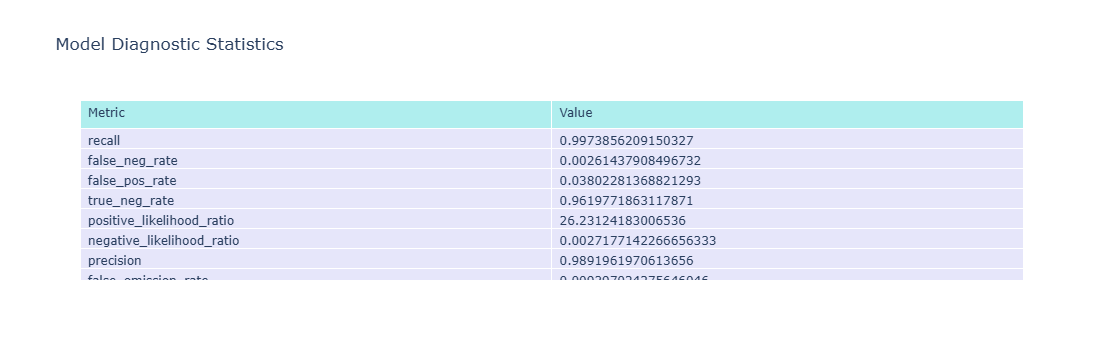

In [156]:
# Interactive Metrics Dashboard
metrics_table = go.Figure(data=[go.Table(
    header=dict(values=['Metric', 'Value'], fill_color='paleturquoise', align='left'),
    cells=dict(values=[list(stats.keys()), list(stats.values())], fill_color='lavender', align='left')
)])
metrics_table.update_layout(title="Model Diagnostic Statistics", template='plotly_white')

# Display the plots
roc_fig.show()
pr_fig.show()
conf_matrix_fig.show()
feature_fig.show()
metrics_table.show()

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1315
           1       0.99      1.00      0.99      4590

    accuracy                           0.99      5905
   macro avg       0.99      0.98      0.98      5905
weighted avg       0.99      0.99      0.99      5905



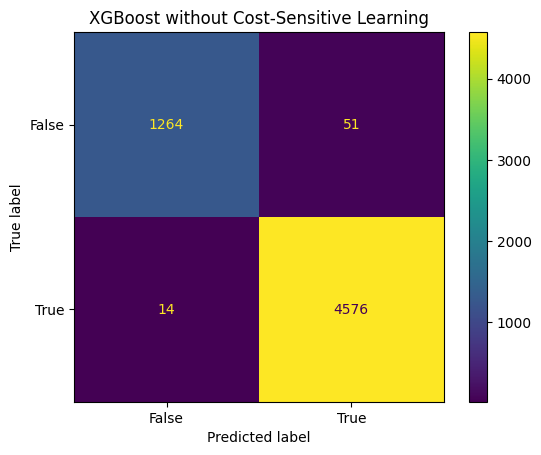

In [158]:
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

xg1 = xgb.XGBClassifier()
xg1.fit(X_train_scaled, y_train)
y_pred1 = xg1.predict(X_test_scaled)

print(classification_report(y_test, y_pred1))

cm1 = metrics.confusion_matrix(y_test, y_pred1)
display_cm1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=[False, True])

display_cm1.plot()
plt.title('XGBoost without Cost-Sensitive Learning')
plt.show()

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1315
           1       0.99      1.00      0.99      4590

    accuracy                           0.99      5905
   macro avg       0.99      0.98      0.99      5905
weighted avg       0.99      0.99      0.99      5905



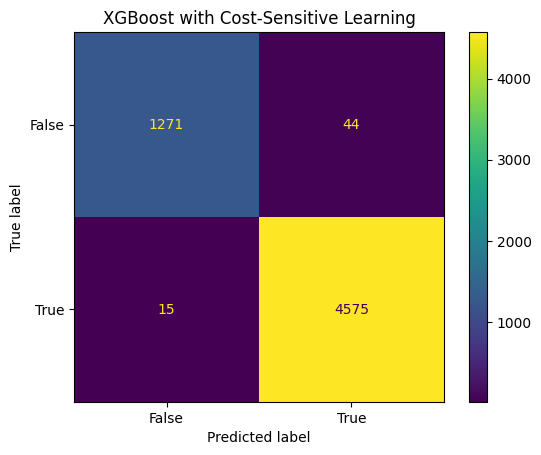

In [160]:
balancing_factor = y_train.value_counts()[0] / y_train.value_counts()[1]  # Balance factor calculation
xg2 = xgb.XGBClassifier(scale_pos_weight=balancing_factor)
xg2.fit(X_train_scaled, y_train)
y_pred2 = xg2.predict(X_test_scaled)

print(classification_report(y_test, y_pred2))

cm2 = metrics.confusion_matrix(y_test, y_pred2)
display_cm2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=[False, True])
display_cm2.plot()
plt.title('XGBoost with Cost-Sensitive Learning')
plt.show()